<a href="https://colab.research.google.com/github/steo85it/pygsr/blob/master/example/gsr_GSS19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hands-on Global Sphere Reconstruction exercise

>[Hands-on Global Sphere Reconstruction exercise](#scrollTo=mDrzxpFZ71PL)

>>[Introduction](#scrollTo=9x974rxD8V4T)

>>[Set-up of the project and of the environment](#scrollTo=f6Xm4aoY9DUv)

>>>[Clone project](#scrollTo=4cP_ziTzwuiu)

>>>[Import all required libraries](#scrollTo=iwFXsuvANK_7)

>>[Main](#scrollTo=nfbpxYOfoBTB)

>>[Step 1: verify the numerical correctness](#scrollTo=IACIeHCdcrXm)

>>[Step 2: consistency of the formal and empirical errors](#scrollTo=IeasOkYjBDo3)

>>[Step 3: Influence of $\sigma_\mathrm{c}$ on the convergence of the solution](#scrollTo=xTCTaGMMDDu5)

>>[Step 4: Influence of GR on the accuracy of the astrometric parameters](#scrollTo=lGYhq4oUM1Lf)



## Introduction
This exercise uses the Google Colab tool to implement a simplified version of a Gaia-like Global Sphere Reconstruction code in Python3. Currently, it uses simulated observations provided by Alexey Butkevich, of the Pulkovo Observatory, Russia, which considers 1000 stars with an approximately uniform distribution on the celestial sphere. Observations are then generated for 5 years according to a nominal Gaia-like scanning law.

The general goal is to give a "hands-on" overview of the main numerical and statistical properties of the global astrometric problem.

The astrometric model is simplified with respect to:
1. The GR metric, which takes into account just the Schwarzschild-like contribution of the Sun (no planetary contributions).
2. The observation equation, which considers only the case of 2 astrometric unknowns (i.e. positions); parallaxes, proper motions, attitude, calibration and global parameters are the true ones and are not reconstructed.

On the other side, the attitude is modelled in a fully consistent relativistic way.

Attention will be paid to:
* The statistical behavior of the reconstruction errors for the astrometric parameters from a given measurement accuracy.
* The influence of the catalog uncertainty on the solution of the linearized problem.
* The influence of the scanning law on the precision of the solution.
* The influence of neglecting GR on the accuracy of the solution.


## Set-up of the project and of the environment
In this section the Python project is cloned from github; it includes both the code and the needed simulated data. Then, common libraries like numpy, astropy, and pandas are imported, along with the project-specific ones that implement, for example, the computation of the coefficients and known terms of the equation system.

The exercise has a negligible computational complexity, thus the project-specific libraries are not compiled, and the source code is readily available to the interested reader.

To proceed, simply evaluate each single cell of this section

### Clone project

In [1]:
!git clone https://github.com/steo85it/pygsr.git

Cloning into 'pygsr'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 221 (delta 117), reused 193 (delta 103), pack-reused 0
Receiving objects: 100% (221/221), 21.48 MiB | 29.96 MiB/s, done.
Resolving deltas: 100% (117/117), done.


If available, upload full dataset of 5 years of observations of 1000 stars. Else, a reduced dataset of 6 observations of a single star is included in the clone.

In [0]:
!#wget -q https://www.dropbox.com/s/cb2bfdybefcg05k/plan_b_full.tar.gz

In [3]:
!#ls -l
!#mv plan_b_full.tar.gz /content/pygsr/auxdir/.
!#cd pygsr/auxdir; tar xvzf plan_b_full.tar.gz; ls -l plan_b_full/

total 355256
-rw-r--r-- 1 root root 363773202 Jun 13 16:05 plan_b_full.tar.gz
drwxr-xr-x 5 root root      4096 Jun 13 16:05 pygsr
drwxr-xr-x 1 root root      4096 May 31 16:17 sample_data
plan_b_full/Ephem.txt
plan_b_full/
plan_b_full/Catalog.txt
plan_b_full/Observ.txt
plan_b_full/Config
plan_b_full/Scan.txt
plan_b_full/Index
total 1043364
-rw-r--r-- 1 1032 1032    126000 May 18 15:37 Catalog.txt
-rw-r--r-- 1 1032 1032       399 May 18 15:09 Config
-rw-r--r-- 1 1032 1032 657450001 May 18 01:33 Ephem.txt
-rw-r--r-- 1 1032 1032     10000 May 18 15:09 Index
-rw-r--r-- 1 1032 1032   5810935 May 18 15:09 Observ.txt
-rw-r--r-- 1 1032 1032 404989200 May 20 00:29 Scan.txt


### Import all required libraries

In [4]:
%cd /content/pygsr
! rm pygsr.py
import glob
import warnings
import time
import random

import numpy as np
import pandas as pd

from astropy import constants as const, units as u
from astropy.coordinates import SkyCoord

from gsrconst import rad2arcsec
from gsr_util import solve_star, load_data, process

from gsr_util import read_parse, read_parse_b
from gsr_obs_eq import obs_eq
import gsrstar

import os
import pickle
from gsropt import projv, opt, debug

/content/pygsr


## Main
The following code loads the data, and selects the source(s) (`chosen_stars` numpy array) to be solved in the system of linearized equations $\mathbf{b}=A\delta\mathbf{x}$. Since the observation equation is linearized, $\delta\mathbf{x}$ represents the *correction* to the catalog values $\mathbf{x}_0$.

Before running it, first set the appropriate options:

1. `options.set_cat_err` sets the stdev of the error of the starting point of the linearization (catalog error). Positions and parallaxes are expressed in arcseconds, proper motions in arcsec/yr.
2. `options.set_meas_err_sigma` sets the stdev of the single-measurement error (in arcsec).
3. `options.set_relat` works as a boolean; "1" switches GR on, "0" switches GR off.

The known term is computed as $b=\phi_\mathrm{obs}-\phi_\mathrm{calc}$, where $\phi_\mathrm{obs}$ represents the observed value (i.e., the measurement) and is always simulated by considering the relativistic model; whereas $\phi_\mathrm{calc}$ represents the prediction made by the astrometric model. The third option, therefore, tells the code whether GR has to be used or not in the computation of $\phi_\mathrm{calc}$.

Once again, evaluate the following cells to before proceeding forward.

In [14]:
%cd /content/pygsr/


if __name__ == '__main__':

    ##############################################
    # launch program and clock
    # -----------------------------
    start = time.time()

    if projv == 'b':

        options = opt()
        ###############################################
        #### Set cat err, meas_err_sigma and relat ####
        ###############################################
        options.set_cat_err({'ra': 1.e-2 / rad2arcsec,
                      'dec': 1.e-2 / rad2arcsec}) #,'par': 0.0 / rad2arcsec,'mu_a': 0.0 / rad2arcsec,'mu_d': 0.0 / rad2arcsec})
        options.set_meas_err_sigma(0.0 / rad2arcsec)
        options.set_relat(1)

        #infils = np.sort(glob.glob('auxdir/plan_b_full/*.txt'))
        infils = np.sort(glob.glob('auxdir/plan_b/*.txt'))
        print(infils)
        dfs = load_data(infils)

        nobs_per_star = pd.DataFrame([(s_id, len(dfs['obs'].loc[dfs['obs'].sourceID == s_id]),
          dfs['cat'].loc[dfs['cat'].sourceID == s_id][['ra']].values[0][0],dfs['cat'].loc[dfs['cat'].sourceID == s_id][['dec']].values[0][0])
                            for s_id in dfs['cat'].sourceID.unique()])

        nobs_per_star.columns = ["id", "num_obs", "ra", "dec"]
        #print(nobs_per_star.max())
        print(nobs_per_star.sort_values(by=["num_obs"]))
        
    # stop clock and print runtime
    # -----------------------------
    end = time.time()
    print('----- Runtime = ' + str(end - start) + ' sec -----' + str((end - start) / 60.) + ' min -----')

/content/pygsr
['auxdir/plan_b/Catalog.txt' 'auxdir/plan_b/Ephem.txt'
 'auxdir/plan_b/Observ.txt' 'auxdir/plan_b/Scan.txt']
   id  num_obs        ra       dec
0   1        6  6.283044  0.749934
----- Runtime = 0.13717293739318848 sec -----0.002286215623219808 min -----


## Step 0: Look at the residuals
Choose one star (currently tested for star #1) from the table printed in the above cell, and solve the system for 1 stars with a given measurement error and plot the residuals (known terms of the equation system) to verify that the perturbations have been created correctly.

In [6]:
        #############################################
        #### Chose here the star(s) to be solved ####
        #############################################
        chosen_stars = dfs['cat'].sourceID.unique()[:1]

        stars = [gsrstar.star(x,
                      cat= dfs['cat'].loc[dfs['cat'].sourceID==x],opt=options)
                 for x in chosen_stars]

        if debug:
            stars = stars[:]

        for s in stars:
            setattr(s,'obs_df',
                    dfs['obs'].loc[dfs['obs'].sourceID==s.id] )
            setattr(s,'eph_df',
                    dfs['eph'].loc[dfs['eph'].frameID.isin(s.obs_df.frameID)] )
            setattr(s,'att_df',
                    dfs['scan'].loc[dfs['scan'].frameID.isin(s.obs_df.frameID)] )
            s.obs_df.reset_index(inplace=True)
            s.eph_df.reset_index(inplace=True)
            s.att_df.reset_index(inplace=True)

        print("Selection done.")

Selection done.


In [7]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

options = opt()
############################
#### Set meas_err_sigma ####
############################
options.set_meas_err_sigma(2.e-2 / rad2arcsec)

for s in stars:
  if len(s.obs_df > 0):

    s.update_options(options)
    
    s.cat = s.cat_orig
    s.set_obs_eq(simobs=True)

cat_err_list = np.array([[0,0]])/ rad2arcsec

for i in range(1):

    cat_err = dict(zip(["ra","dec"],cat_err_list[i,:]))
    options.set_cat_err(cat_err) #,'par': 0.0 / rad2arcsec,'mu_a': 0.0 / rad2arcsec,'mu_d': 0.0 / rad2arcsec})
    options.set_relat(1)
  
    # check numerical ders
    [s.numeric_partials() for s in stars]
    # define and apply perturbation to catalog : sigma pars in as, as/y
    [s.perturb(sigma_pert=options.sigma_pert) for s in stars if len(s.obs_df > 0)]
    # TODO change to len(s.obs_df > 0) when using full dataset
    [s.set_obs_eq() for s in stars if len(s.obs_df > 0)]

    # show the residuals (in mas)
    kt = np.deg2rad(stars[0].obs_eq.b)*rad2arcsec*1000
    print("Residuals in mas")
    print(kt)

    for s in stars:

      # solution based on numerical partials
      subset_num_part = s.num_part.loc[:, list(s.pert.keys())].values
      x = np.linalg.lstsq(subset_num_part, s.obs_eq.b, rcond=None)
      print("Solution vector x_0 (rad):", x)
      s.obs_eq.x = x

      x = s.obs_eq.x[0]
      print("discrepancies on parameter retrieval")
      print(list(s.pert.values())-x)



Residuals in mas
[-18.83430809  27.93156209  13.59428896  -7.41007135  20.32697788
   1.44240046  -3.58392975  16.62198431  26.18074729  -3.87775482
 -19.86499407  12.93963261   6.67335968 -32.91343521  11.17779532
  10.28313326 -48.08238665  30.62165186 -15.92931681  40.07297034
  11.93925496 -30.07361765 -24.42872826  18.02240301   9.0739746
  -1.60466085  25.16206595 -11.0444001  -44.55154584  27.10482987
  39.63066159  -5.76487491   2.38246622 -36.08659864   3.20724358
   1.01319427   3.81747779  19.81212477 -13.46059968  26.48164929
 -23.32980276  -0.16752359 -10.07260113  11.05529394  18.40387336
 -36.00526721  -9.37099565 -24.14006359  -3.74245796 -52.23215055
  -7.15000097  20.59609609 -15.37018194  -8.50598232  46.42299947
   2.31808458 -19.60398042 -16.0233008    6.78870817  24.2524843
  -9.82587099  22.91655892 -26.49357325   6.12535093  18.49638007
  11.3533184   16.21777626  11.21434625  14.72768208   7.58017047
  -4.77939398 -11.93778146  22.20486549  19.03075879   8.5830

## Step 1: verify the numerical correctness of the model
We take just one star, setting the properties to have neither measurement error nor catalog errors (i.e. $\sigma_\mathrm{m}=\sigma_\mathrm{c}=0$, GR On).
We expect to get an exact solution up to the numerical accuracy.

Evaluate the numerical accuracy.

In [8]:
options = opt()
###############################################
#### Set cat err, meas_err_sigma and relat ####
###############################################
options.set_cat_err({'ra': 0.0 / rad2arcsec,
              'dec': 0.0 / rad2arcsec}) #,'par': 0.0 / rad2arcsec,'mu_a': 0.0 / rad2arcsec,'mu_d': 0.0 / rad2arcsec})
options.set_meas_err_sigma(0.0 / rad2arcsec)
# options.set_debug(0)
options.set_relat(1)

process(stars,options)

for s in stars:

    _ = solve_star(s)

x = stars[0].obs_eq.x[0]
print(list(stars[0].pert.values())-x)

Solution for star # 1
Perts to retrieve : {'ra': 0.0, 'dec': 0.0}
analyt sol (rad, parts*100) :  (array([-2.74711730e-08,  1.45847725e-08]), array([3.50135352e-09]), 2, array([451.51803526, 297.67766921]))
num sol (rad): (array([-2.88546418e-08,  1.52774351e-08]), array([3.50082779e-09]), 2, array([431.72338862, 284.49294971]))
[ 2.88546418e-08 -1.52774351e-08]


## Step 2: consistency of the formal and empirical errors
Perform a Monte Carlo run of the 1 star solution (e.g. 100  times) with $\sigma_\mathrm{m}\not=0$ and $\sigma_\mathrm{c}=0$ (GR On).
Compute the variance-covariance matrix of the positions (ra, dec) $\sigma_\mathrm{m}^2\,(A^\mathrm{T}A)^{-1}$ and compare it with the empirical distribution of the errors $\mathbf{x}_\mathrm{true}-\mathbf{x}_\mathrm{adj}$ from the Monte Carlo run for each of the 2 parameters.



End loop
[[6.70616859 1.43641073]
 [1.43641073 4.4484161 ]]


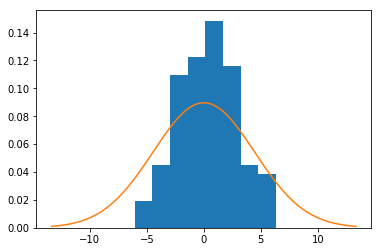

In [9]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

meas_err_list = [2.e-2]

options = opt()
options.set_cat_err({'ra': 0.0 / rad2arcsec,'dec': 0.0 / rad2arcsec})
options.set_meas_err_sigma(0. / rad2arcsec)
# options.set_debug(0)
options.set_relat(1)

for s in stars:
  if len(s.obs_df > 0):

    ext_num = 100
    obs_iter = []
    for i in range(ext_num):

      options.set_meas_err_sigma(meas_err_list[0] / rad2arcsec)
      s.update_options(options)

      s.cat = s.cat_orig
      s.set_obs_eq(simobs=True,rand_seed=i)
      
      obs_iter.extend(s.obs_df.eta.values)
      
    print("End loop")

    # check numerical ders
    [s.numeric_partials() for s in stars]
    # define and apply perturbation to catalog : sigma pars in as, as/y
    [s.perturb(sigma_pert=options.sigma_pert) for s in stars if len(s.obs_df > 0)]
    # TODO change to len(s.obs_df > 0) when using full dataset
    [s.set_obs_eq() for s in stars if len(s.obs_df > 0)]

    # show the residuals (in mas)
    obs_iter = np.reshape(obs_iter,(ext_num,-1))
    phi_calc = s.obs_eq.b + s.obs_df.eta.values
    b_iter = obs_iter - phi_calc
    
    kt = np.deg2rad(b_iter)*rad2arcsec*1000
    
    subset_num_part = s.num_part.loc[:, list(s.pert.keys())].values
    x = [np.linalg.lstsq(subset_num_part, b_iter[i,:], rcond=None) for i in range(ext_num)]
    x = np.vstack(np.array(x)[:,0])
    x = x*rad2arcsec*1000
    
    plt.hist(x[:,1], bins='auto',density=True)  # arguments are passed to np.histogram
    mu = 0
    variance = (20)**2
    sigma = math.sqrt(variance)
    
    A = stars[0].obs_eq.A.values[:,:2]
    #print(A)
    b = stars[0].obs_eq.b
    #print(b)
    ATA = np.matmul(np.transpose(A),A)
    InvA = np.linalg.inv(ATA)
    sigma_pars = sigma*InvA**(1/2)
    print(sigma_pars)
    
    sigma = sigma_pars[1,1]
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma))
    plt.show()

In [10]:
A = stars[0].obs_eq.A.values[:,:2]
#print(A)
b = stars[0].obs_eq.b
#print(b)
ATA = np.matmul(np.transpose(A),A)
InvA = np.linalg.inv(ATA)
CovM = 100*InvA**(1/2)
corr = CovM[0:1,1:2]/(CovM[0:1,0:1]*CovM[1:2,1:2])**0.5
print(corr)



[[0.26298968]]


## Step 3: Influence of $\sigma_\mathrm{c}$ on the convergence of the solution
Run the 1-star solution repeatedly with $\sigma_\mathrm{m}=0$ and an increasing $\sigma_\mathrm{c}$ (GR ON) and evaluate the quality of the solution for the astrometric parameters.

Try with, e.g., $\sigma_\mathrm{c}=10, 50, 100, 500, 1000,2000,5000,10000\,\mathrm{mas}$.

What can you infer about the influence of the catalog error on the accuracy of the estimated parameters? (Hint: linearized problem.)


In [11]:
for s in stars:
  if len(s.obs_df > 0):

    options = opt()
    options.set_meas_err_sigma(0. / rad2arcsec)
    options.set_relat(1)
    s.update_options(options)
    
    s.cat = s.cat_orig
    s.set_obs_eq(simobs=True)

    cat_err_list = np.array([[1.e-2,1.e-2],[1.e-1,1.e-1]])/ rad2arcsec

    ###############################################
    #### Set cat err, meas_err_sigma and relat ####
    ###############################################

    for i in range(2):

        cat_err = dict(zip(["ra","dec"],cat_err_list[i,:]))
        options.set_cat_err(cat_err) #,'par': 0.0 / rad2arcsec,'mu_a': 0.0 / rad2arcsec,'mu_d': 0.0 / rad2arcsec})
        options.set_meas_err_sigma(0. / rad2arcsec)
        options.set_relat(1)

        s.update_options(options)

        # check numerical ders
        [s.numeric_partials() for s in stars]
        # define and apply perturbation to catalog : sigma pars in as, as/y
        [s.perturb(sigma_pert=options.sigma_pert) for s in stars if len(s.obs_df > 0)]
        [s.set_obs_eq() for s in stars if len(s.obs_df > 0)]

        # show the residuals (in mas)
        kt = np.deg2rad(stars[0].obs_eq.b)*rad2arcsec*1000
        print(kt)

        for s in stars:

          # solution based on numerical partials
          subset_num_part = s.num_part.loc[:, list(s.pert.keys())].values
          x = np.linalg.lstsq(subset_num_part, s.obs_eq.b, rcond=None)
          print("num sol (rad):", x)
          s.obs_eq.x = x

          x = s.obs_eq.x[0]
          print("discrepancies on parameter retrieval")
          print(list(s.pert.values())-x)

[ 17.13010147  17.10404587  17.09291646  11.25746734   9.17273415
  17.28894562 -17.09886571 -17.10545503  -9.50791165  -9.49064291
 -10.75780468   6.75207686   6.82008381   6.98335967  15.68816862
  15.66419356  12.73564531  12.73711156   8.14975626   8.2117881
  16.41696404  16.44039149 -16.18046692 -16.19013034  -9.60829334
  -9.50060684   7.59162693  13.85504984  13.83713366  14.24074848
   7.98161928   8.05947263   8.24616719   8.32411638   8.51088499
  12.64863712  12.71015579  12.85377324  12.9137488  -11.34184651
 -11.27416389 -11.11033377 -11.04124248 -10.87406973 -10.80359939
  -7.46642625  -7.3849733   -7.18971737  -7.10819139  -6.912911
  -6.83143822 -14.90027299 -13.40388949 -13.42719815  -8.66895436
  -8.52833463   8.68553613   8.72780201  12.10540779  15.66731618
 -15.75197113 -15.67681011  -6.88414954  -6.81869599 -13.4747043
 -13.4711269  -15.61884092  -7.99980571  -7.92907232   8.19772807
   8.27738024   8.46750622   8.54648908   8.73497337   8.8132555
   9.00002255  

## Step 4: Influence of GR on the accuracy of the astrometric parameters
Run the 1-star solution with $\sigma_\mathrm{m}=\sigma_\mathrm{c}=0$, but switch GR Off.
Compare the results with those of the first case.

In [12]:
for s in stars:
  if len(s.obs_df > 0):

    # TODO change to len(s.obs_df > 0) when using full dataset
    options = opt()
    ###############################################
    #### Set cat err, meas_err_sigma and relat ####
    ###############################################
    options.set_cat_err({'ra': 0.0 / rad2arcsec,
                  'dec': 0.0 / rad2arcsec}) #,'par': 0.0 / rad2arcsec,'mu_a': 0.0 / rad2arcsec,'mu_d': 0.0 / rad2arcsec})
    options.set_meas_err_sigma(0.0 / rad2arcsec)
    options.set_relat(1)
    print(options.relat)
    s.update_options(options)

    [s.set_obs_eq(simobs=True) for s in stars if len(s.obs_df > 0)]

    options.set_relat(0)
    print(options.relat)
    s.update_options(options)

    # check numerical ders
    [s.numeric_partials() for s in stars]
    # define and apply perturbation to catalog : sigma pars in as, as/y
    [s.perturb(sigma_pert=options.sigma_pert) for s in stars if len(s.obs_df > 0)]
    # TODO change to len(s.obs_df > 0) when using full dataset
    [s.set_obs_eq() for s in stars if len(s.obs_df > 0)]

    # show the residuals (in mas)
    print('Known terms (mas)')
    kt = np.deg2rad(s.obs_eq.b)*rad2arcsec*1000
    print(kt)

1
0
Known terms (mas)
[-175.35592448 -169.24206978 -175.01466081 -114.34913919  -96.9372566
 -170.83302003  175.23830697  169.16292544   96.76380619   90.43944801
  106.7595598   -62.89569463  -69.4691701   -65.23231789 -155.68040215
 -161.19394414 -123.54846981 -129.41375875  -80.86701535  -87.39762748
 -162.6960278  -168.8609907   166.39758754  160.45912834   95.32651186
  100.37863878  -77.26388697 -137.60279879 -143.27127351 -138.92855925
  -79.17819922  -85.90455545  -81.81894853  -88.54639801  -84.45990576
 -125.69205715 -132.15551633 -127.72486831 -134.17354273  115.32778634
  108.55170907  112.97632343  106.18599512  110.57810485  103.77362575
   76.09179491   69.17316673   73.29589504   66.37620884   70.49927993
   63.57957984  149.31881785  131.74578052  135.09460105   90.57329819
   86.05996797  -86.93568431  -84.2521131  -124.75576418 -158.04798233
  158.90181564  155.07014032   65.64338959   68.03754548  135.23624381
  138.25625649  157.52426634   80.81317638   83.16223619

## Step 5: Influence of the scanning law
Generate an array with the ecliptic coordinates of the stars and the corresponding number of observations; then plot the number of observations as function of the ecliptic latitude.

What can you say about the relation with the satellite scanning law?

PS: The catalog is given in equatorial coordinates. You can find an example of the needed coordinate conversion in the next cell.

0.9019769359854876 359.99190794303644
-86.37238725069987 86.34579634715192
-89.46487786021007 86.75846804481482


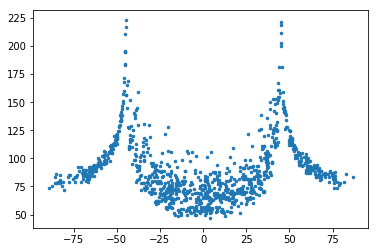

In [13]:
import coords
import matplotlib.pyplot as plt

ras=np.rad2deg(nobs_per_star.loc[:,"ra"].values)
decs=np.rad2deg(nobs_per_star.loc[:,"dec"].values)
nobs=nobs_per_star.loc[:,"num_obs"].values

print(np.min(ras),np.max(ras))
print(np.min(decs),np.max(decs))

l, b = coords.eq2ec(ra=ras, dec=decs)

print(np.min(b),np.max(b))

area = np.pi*2

plt.scatter(b, nobs, s=area)
